## Questions

1. Which distribution does the standard deviation in equation for RANSAC error threshold $t = 5.99\sigma^2$ represent?

A: I'm investigating

In [14]:
# Hard path reference, can be run without installing robot_perception
from robot_perception.src.homography_estimation import normalized_dlt, util
# After installing robot_perception package can run this directly
#from homography_estimation import normalized_dlt, util
import numpy as np
import random
from scipy.ndimage import imread
import matplotlib.pyplot as plt
%matplotlib inline

img1 = imread("boat/img1+points.png")
img2 = imread("boat/img2+points.png")

with open("boat/homography.txt") as f:
    lines = f.readlines()

# Get the text coordinates
lines[0] = lines[0][lines[0].find('[') + 1:lines[0].find(']')]
lines[1] = lines[1][lines[1].find('[') + 1:lines[1].find(']')]

# Split coordinate pairs
lines[0] = lines[0].split(';')
lines[1] = lines[1].split(';')

# Map coordinates to 2D int arrays
x = []
x_tick = []
for i in range(len(lines[0])):
    x.append(list(map(int, lines[0][i].split(','))))
    x_tick.append(list(map(int, lines[1][i].split(','))))

x = np.array(x)
x_tick = np.array(x_tick)

In [23]:
class RANSAC:
    def __init__(self, error_threshold, p_outlier, p=0.99, sample_size_min=4):
        """
        Init function for RANSAC

        :param error_threshold:
        :param p_outlier: probability of observing an outlier in the samples
        :param p: probability that at least one of the sets of random samples does not include an outlier
        :param sample_min_size: minimum sample size
        """
        self._error_threshold = error_threshold
        self._p_outlier = p_outlier
        self._p = p
        self._sample_size_min = sample_size_min

    def get_homography(self, x, x_tick):
        """
        Perform RANSAC algorithm with DLT

        :param x:
        :param x_tick:
        """
        if x.shape != x_tick.shape:
            print("ransac: input matrices need to have the same dimensions.")
            return None
        if self._sample_size_min < 4:
            print("ransac: Need at least 4 samples for homography calculation.")
            return None

        iteration_num = calculate_iteration_num(self._p, self._p_outlier, self._sample_size_min)
        #print("number of iterations: %d" % iteration_num)
        sample_num = len(x)
        inlier_num_threshold = int((1 - self._p_outlier) * sample_num * 0.8)

        for i in range(iteration_num*2):
            # Pick and fit sample of minimum size
            random_indices = get_random_indices(sample_num, self._sample_size_min)
            homography = normalized_dlt.get_homography(x[random_indices], x_tick[random_indices])

            inlier_indices = []
            for j in range(sample_num):
                if (calculate_transfer_error(x[j], x_tick[j], homography)) < error_threshold:
                    inlier_indices.append(j)
            #print(len(inlier_indices))
            if len(inlier_indices) > inlier_num_threshold:
                return inlier_indices, normalized_dlt.get_homography(x[inlier_indices], x_tick[inlier_indices])
        print("ransac: failed to find sufficient inliers")
        return None


def get_inlier_indices(x, x_tick, homography, error_threshold, sample_num):
    inlier_indices = []
    for j in range(sample_num):
        if (calculate_transfer_error(x[j], x_tick[j], homography)) < error_threshold:
            inlier_indices.append(j)
    return inlier_indices


def calculate_iteration_num(p, p_outlier, sample_size_min):
    """
    N = log10(1-p)/log10(1 - (1 - p_outlier)^sample_size_min)

    :param p_outlier: probability of observing an outlier in the samples
    :param p: probability that at least one of the sets of random samples does not include an outlier
    :param sample_min_size: minimum sample size
    """
    iteration_num = np.log10(1 - p) / np.log10(1 - np.power(1 - p_outlier, sample_size_min))
    return int(iteration_num)


def calculate_transfer_error(x, x_tick, homography):
    """
    Calculate symmetric transfer error between 2 similar points using a given homography
    d = sqrt(d(x, x'.inv(H))^2 + d(x', x.H)^2)

    :param x: (1, 2) array of coordinates of ONE original point
    :param x_tick: (1, 2) array of coordinates of ONE similar point
    :return: symmetric transfer error
    """
    x_tick_transformed = np.dot(homography, np.append(x, 1.))
    x_transformed = np.dot(np.linalg.inv(homography), np.append(x_tick, 1.))
    squared_distance = util.euclidean_squared(x, x_transformed[:2]) +\
                       util.euclidean_squared(x_tick, x_tick_transformed[:2])

    return np.sqrt(squared_distance)


def get_random_indices(total_num_sample, num_sample=4):
    if num_sample > total_num_sample:
        return None
    random.seed()
    random_indices = []
    for i in range(num_sample):
        random_indices.append(random.randint(0, total_num_sample - 1))

    return random_indices


In [24]:
H = normalized_dlt.get_homography(x, x_tick)
#print(np.linalg.inv(H))

average_error = 0.
for i in range(len(x)):
    distance = calculate_transfer_error(x[i], x_tick[i], H)
    #print(distance)
    average_error = average_error + distance

average_error = average_error / len(x)

In [22]:
print(average_error)
ransac_inst = RANSAC(average_error*45, 0.4)
inliers, homography_ransac = ransac(x, x_tick, average_error*45, 0.4)
print(inliers)
print(homography_ransac)

1.99665799113


TypeError: 'RANSAC' object is not callable

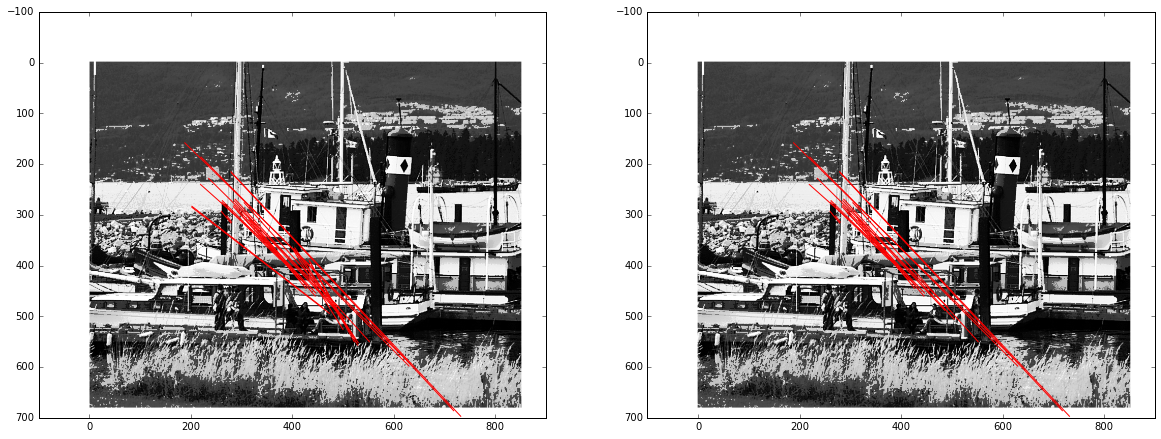

In [7]:

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
util.plot_lines_on_image(img1, x, x_tick)
plt.subplot(1,2,2)
util.plot_lines_on_image(img1, x[inliers], x_tick[inliers])
plt.show()

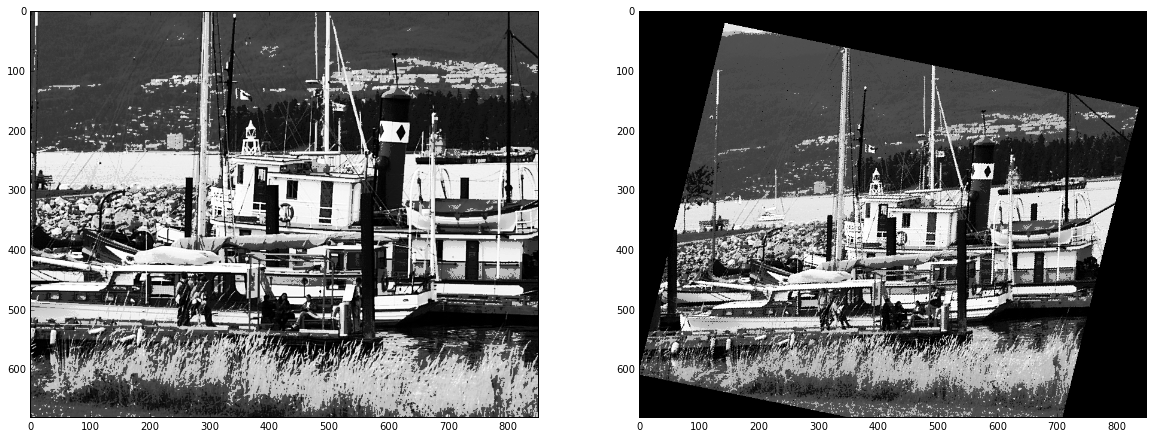

In [10]:
img2_recon_ransac = util.transform_image(img2, homography_ransac)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2_recon_ransac, cmap='gray')

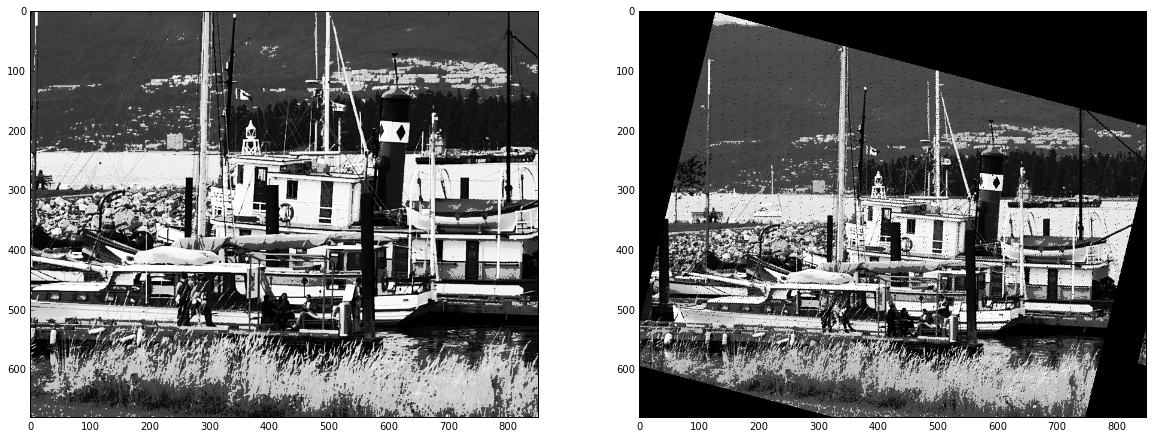

In [9]:
img2_recon = util.transform_image(img2, H)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2_recon, cmap='gray')